# **Mounting Google Drive in Colab**

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Unzipping Dataset to Colab Workspace**

In [27]:
import zipfile
import os

# Path to your ZIP file in Google Drive
zip_path = '/content/drive/MyDrive/dataset.zip'

# Destination folder in Colab
extract_path = '/content/images'
os.makedirs(extract_path, exist_ok=True)

# Extract
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Extracted files to {extract_path}")

Extracted files to /content/images


# **Importing Required Libraries and Modules**

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
from tqdm import tqdm
from torch.optim.swa_utils import AveragedModel, SWALR, update_bn
import os
import pandas as pd
import time
from datetime import datetime

# **Custom VGG16 with Squeeze-and-Excitation (SE) Blocks**

In [29]:
# -----------------------------
# 1️⃣ Squeeze-and-Excitation Block
# -----------------------------
class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

# -----------------------------
# 2️⃣ Custom VGG16 Model with SE
# -----------------------------
class CustomVGG16(nn.Module):
    def __init__(self, in_channels=3, num_classes=2):
        super(CustomVGG16, self).__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(in_channels, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2), SEBlock(64),
            # Block 2
            nn.Conv2d(64,128,3,padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.Conv2d(128,128,3,padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2), SEBlock(128),
            # Block 3
            nn.Conv2d(128,256,3,padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.Conv2d(256,256,3,padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.Conv2d(256,256,3,padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2), SEBlock(256),
            # Block 4
            nn.Conv2d(256,512,3,padding=1), nn.BatchNorm2d(512), nn.ReLU(inplace=True),
            nn.Conv2d(512,512,3,padding=1), nn.BatchNorm2d(512), nn.ReLU(inplace=True),
            nn.Conv2d(512,512,3,padding=1), nn.BatchNorm2d(512), nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2), SEBlock(512),
            # Block 5
            nn.Conv2d(512,512,3,padding=1), nn.BatchNorm2d(512), nn.ReLU(inplace=True),
            nn.Conv2d(512,512,3,padding=1), nn.BatchNorm2d(512), nn.ReLU(inplace=True),
            nn.Conv2d(512,512,3,padding=1), nn.BatchNorm2d(512), nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2), SEBlock(512),
        )
        self.classifier = nn.Sequential(
            nn.Linear(512*7*7, 4096), nn.ReLU(inplace=True), nn.Dropout(0.5),
            nn.Linear(4096, 1024), nn.ReLU(inplace=True), nn.Dropout(0.5),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x,1)
        return self.classifier(x)

# **Model Training Hyperparameters and Data Augmentation Probabilities**

In [30]:
# -----------------------------
# 3️⃣ Hyperparameters
# -----------------------------
batch_size = 128
learning_rate = 1e-4
num_epochs = 50
p_mixup = 0.5
p_cutmix = 0.25
alpha_mixup = 0.4
alpha_cutmix = 1.0
early_lr_min, early_lr_max = 1e-6, 5e-6

# **Image Transformations: Training Augmentations & Validation Normalization**

In [31]:
# -----------------------------
# 4️⃣ Transforms
# -----------------------------
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomResizedCrop(224, scale=(0.85, 1.0)),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), shear=10),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.1), ratio=(0.3, 3.3))
])
transform_val = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# **Loading Dataset, Splitting Train/Validation, and Creating DataLoaders**

In [32]:
# -----------------------------
# 5️⃣ Dataset & DataLoader
# -----------------------------
dataset_path = "images/"
full_dataset = datasets.ImageFolder(root=dataset_path, transform=transform_train)
num_classes = len(full_dataset.classes)
print("Detected classes:", full_dataset.classes)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])
val_dataset.dataset.transform = transform_val

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

Detected classes: ['snake', 'spider']


# **Setting Device, Initializing Custom VGG16, and Freezing Early Layers**

In [33]:
# -----------------------------
# 6️⃣ Device & Model
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomVGG16(num_classes=num_classes).to(device)

# Freeze first 3 blocks initially
for param in list(model.features[:16].parameters()):
    param.requires_grad = False

# **Optimizer, Learning Rate Scheduler, and Mixed-Precision Scaler**

In [34]:
# -----------------------------
# 7️⃣ Optimizer, Scheduler, Scaler
# -----------------------------
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6)
scaler = torch.amp.GradScaler('cuda')

# **Loss Function: Cross-Entropy with Label Smoothing**

In [35]:
# -----------------------------
# 8️⃣ Class Weights, Loss
# -----------------------------
targets = [label for _, label in full_dataset.samples]
class_counts = np.bincount(targets)
class_weights = 1. / class_counts
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)

# **Model Checkpoint Path and Training State Initialization**

In [36]:
# -----------------------------
# 9️⃣ Checkpoint Path
# -----------------------------
checkpoint_path = "/content/drive/MyDrive/vgg16_se_checkpoint.pth"
start_epoch = 0
best_acc = 0.0

# **Restoring Model Checkpoint: Loading Weights and Scheduler State**

In [37]:
# -----------------------------
# 🔄 Restore checkpoint (ignore optimizer state)
# -----------------------------
if os.path.exists(checkpoint_path):
    print("🔄 Restoring checkpoint from Google Drive...")
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state'])
    scheduler.load_state_dict(checkpoint['scheduler_state'])
    start_epoch = checkpoint['epoch'] + 1
    best_acc = checkpoint['best_acc']
    print(f"✅ Restored checkpoint (epoch {start_epoch}, val_acc {best_acc:.2f}%)")

🔄 Restoring checkpoint from Google Drive...
✅ Restored checkpoint (epoch 50, val_acc 98.68%)


# **Data Augmentation Helpers: Mixup and CutMix Implementations**

In [38]:
# -----------------------------
# 🔟 Mixup & CutMix helper
# -----------------------------
def rand_bbox(size, lam):
    W, H = size[2], size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w, cut_h = int(W * cut_rat), int(H * cut_rat)
    cx, cy = np.random.randint(W), np.random.randint(H)
    x1, x2 = np.clip(cx - cut_w // 2, 0, W), np.clip(cx + cut_w // 2, 0, W)
    y1, y2 = np.clip(cy - cut_h // 2, 0, H), np.clip(cy + cut_h // 2, 0, H)
    return x1, y1, x2, y2

def apply_mixup_cutmix(images, labels):
    if np.random.rand() < p_mixup:
        lam = np.random.beta(alpha_mixup, alpha_mixup)
        index = torch.randperm(images.size(0)).to(device)
        mixed_x = lam * images + (1 - lam) * images[index, :]
        y_a, y_b = labels, labels[index]
        return mixed_x, y_a, y_b, lam, "mixup"
    elif np.random.rand() < p_cutmix:
        lam = np.random.beta(alpha_cutmix, alpha_cutmix)
        index = torch.randperm(images.size(0)).to(device)
        y_a, y_b = labels, labels[index]
        x1, y1, x2, y2 = rand_bbox(images.size(), lam)
        images[:, :, y1:y2, x1:x2] = images[index, :, y1:y2, x1:x2]
        lam = 1 - ((x2 - x1) * (y2 - y1) / (images.size(-1) * images.size(-2)))
        return images, y_a, y_b, lam, "cutmix"
    else:
        return images, labels, labels, 1.0, "none"

# **Initialize CSV Logger to Record Training Metrics, Epoch Info, and Model Parameters**

In [39]:
# -----------------------------
# 📊 CSV Logger Setup
# -----------------------------
log_path = "/content/drive/MyDrive/vgg16_se_training_log.csv"
if not os.path.exists(log_path):
    df = pd.DataFrame(columns=[
        "epoch","timestamp","train_loss","train_acc","val_acc","learning_rate",
        "best_val_acc","epoch_time_sec","trainable_parameters","frozen_parameters",
        "total_parameters","trainable_layers","frozen_layers","total_layers"
    ])
    df.to_csv(log_path, index=False)

# **Training Loop: Gradual Layer-wise Fine-Tuning with Ramp-up, Mixup/CutMix, and SWA**

In [40]:
# -----------------------------
# 🔟 Training Loop with Gradual Layer-wise Fine-tuning + Ramp-up + SWA
# -----------------------------
use_swa = True
swa_start = int(0.7 * num_epochs)
swa_model = AveragedModel(model)
swa_scheduler = None
ramp_up_epochs = 5

def create_param_groups(model, early_lr):
    return [
        {'params': model.features[:16].parameters(), 'lr': early_lr},
        {'params': model.features[16:].parameters(), 'lr': learning_rate},
        {'params': model.classifier.parameters(), 'lr': learning_rate}
    ]

for epoch in range(start_epoch, num_epochs):
    start_time = time.time()
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    if epoch >= 30:
        if epoch == 30:
            for param in model.features.parameters():
                param.requires_grad = True
            print("🔓 All layers unfrozen with layer-wise ramp-up learning rates.")

        ramp_progress = min(epoch - 30 + 1, ramp_up_epochs) / ramp_up_epochs
        early_lr = early_lr_min + (early_lr_max - early_lr_min) * ramp_progress
        optimizer = optim.AdamW(create_param_groups(model, early_lr), weight_decay=1e-3)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6)

    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        imgs, labels = imgs.to(device), labels.to(device)
        imgs, targets_a, targets_b, lam, mode = apply_mixup_cutmix(imgs, labels)
        optimizer.zero_grad()
        with torch.amp.autocast('cuda'):
            outputs = model(imgs)
            loss = lam * criterion(outputs, targets_a) + (1-lam)*criterion(outputs, targets_b)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        _, preds = outputs.max(1)
        correct += (preds==labels).sum().item()
        total += labels.size(0)

    train_acc = 100*correct/total

    torch.cuda.empty_cache()

    # Validation
    model.eval()
    correct_val, total_val = 0,0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, preds = outputs.max(1)
            correct_val += (preds==labels).sum().item()
            total_val += labels.size(0)
    val_acc = 100*correct_val/total_val
    scheduler.step()
    print(f"\nEpoch {epoch+1} → Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

    # 🧾 Logging to CSV
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    epoch_time_sec = time.time() - start_time
    current_lr = optimizer.param_groups[0]['lr']

    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    frozen_params = total_params - trainable_params
    total_layers = len([p for p in model.parameters()])
    trainable_layers = len([p for p in model.parameters() if p.requires_grad])
    frozen_layers = total_layers - trainable_layers

    new_row = pd.DataFrame([{
        "epoch": epoch+1,
        "timestamp": timestamp,
        "train_loss": running_loss/len(train_loader),
        "train_acc": train_acc,
        "val_acc": val_acc,
        "learning_rate": current_lr,
        "best_val_acc": best_acc,
        "epoch_time_sec": epoch_time_sec,
        "trainable_parameters": trainable_params,
        "frozen_parameters": frozen_params,
        "total_parameters": total_params,
        "trainable_layers": trainable_layers,
        "frozen_layers": frozen_layers,
        "total_layers": total_layers
    }])
    new_row.to_csv(log_path, mode='a', header=False, index=False)

    # SWA
    if use_swa and epoch >= swa_start:
        swa_model.update_parameters(model)
        if swa_scheduler is None:
            swa_scheduler = SWALR(optimizer, swa_lr=5e-6)

    # Save checkpoint
    if val_acc > best_acc:
        best_acc = val_acc
    torch.save({
        'epoch': epoch,
        'model_state': model.state_dict(),
        'optimizer_state': optimizer.state_dict(),
        'scheduler_state': scheduler.state_dict(),
        'best_acc': best_acc
    }, checkpoint_path)

# Apply SWA
if use_swa:
    update_bn(train_loader, swa_model, device=device)
    model = swa_model

# **Creating SWA Wrapper and Loading Base Model Weights for Stochastic Weight Averaging**

In [41]:
from torch.optim.swa_utils import AveragedModel, update_bn
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Recreate your base architecture
base_model = CustomVGG16(num_classes=num_classes).to(device)

# Create an SWA wrapper
swa_model = AveragedModel(base_model)

# Load your last saved normal model weights
checkpoint = torch.load(checkpoint_path, map_location=device)
base_model.load_state_dict(checkpoint['model_state'])

# Copy those weights into the SWA model
swa_model.update_parameters(base_model)

# **Recomputing BatchNorm Running Statistics Using Training Data for SWA Model**

In [42]:
update_bn(train_loader, swa_model, device=device)

# **Saving the Final Stochastic Weight Averaged (SWA) Model to Google Drive**

In [43]:
swa_path = "/content/drive/MyDrive/vgg16_se_swa_final.pth"
torch.save({'model_state': swa_model.state_dict()}, swa_path)
print("✅ SWA model saved at:", swa_path)

✅ SWA model saved at: /content/drive/MyDrive/vgg16_se_swa_final.pth


# **SWA Model: Accuracy & Classification Metrics**

In [44]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

swa_model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = swa_model(imgs)
        _, preds = outputs.max(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

swa_acc = accuracy_score(all_labels, all_preds)
print(f"\n🌊 SWA Final Accuracy: {swa_acc*100:.2f}%")
print("\nClassification Report:\n", classification_report(all_labels, all_preds))
print("Confusion Matrix:\n", confusion_matrix(all_labels, all_preds))


🌊 SWA Final Accuracy: 99.47%

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      3398
           1       1.00      0.99      0.99      3584

    accuracy                           0.99      6982
   macro avg       0.99      0.99      0.99      6982
weighted avg       0.99      0.99      0.99      6982

Confusion Matrix:
 [[3381   17]
 [  20 3564]]


# **Model Evaluation: Comparing Standard VGG16 vs SWA-Enhanced Model**

In [45]:
# Load normal model
normal_model = CustomVGG16(num_classes=num_classes).to(device)
normal_model.load_state_dict(checkpoint['model_state'])
normal_model.eval()

def evaluate(model):
    all_preds, all_labels = [], []
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, preds = outputs.max(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return accuracy_score(all_labels, all_preds)

normal_acc = evaluate(normal_model)
swa_acc = evaluate(swa_model)

print(f"🧩 Normal Accuracy: {normal_acc*100:.2f}%")
print(f"🌊 SWA Accuracy:    {swa_acc*100:.2f}%")

🧩 Normal Accuracy: 99.20%
🌊 SWA Accuracy:    99.47%


# **Predicting Snake vs Spider on New Images**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Saving 1280px-Brachypelma_vagans_p1.jpg to 1280px-Brachypelma_vagans_p1 (1).jpg


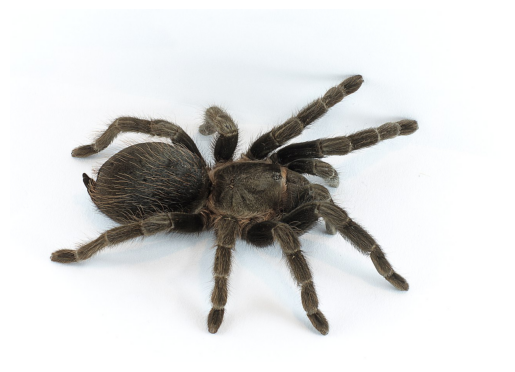

Prediction: 🕷️ Spider | Confidence: 95.76%


In [46]:
# 1️⃣ Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 2️⃣ Imports
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
from google.colab import files
import matplotlib.pyplot as plt

# -----------------------------
# 3️⃣ SE Block & Custom VGG16
# -----------------------------
class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )
    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class CustomVGG16(nn.Module):
    def __init__(self, in_channels=3, num_classes=2):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2), SEBlock(64),
            nn.Conv2d(64,128,3,padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.Conv2d(128,128,3,padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2), SEBlock(128),
            nn.Conv2d(128,256,3,padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.Conv2d(256,256,3,padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.Conv2d(256,256,3,padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2), SEBlock(256),
            nn.Conv2d(256,512,3,padding=1), nn.BatchNorm2d(512), nn.ReLU(inplace=True),
            nn.Conv2d(512,512,3,padding=1), nn.BatchNorm2d(512), nn.ReLU(inplace=True),
            nn.Conv2d(512,512,3,padding=1), nn.BatchNorm2d(512), nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2), SEBlock(512),
            nn.Conv2d(512,512,3,padding=1), nn.BatchNorm2d(512), nn.ReLU(inplace=True),
            nn.Conv2d(512,512,3,padding=1), nn.BatchNorm2d(512), nn.ReLU(inplace=True),
            nn.Conv2d(512,512,3,padding=1), nn.BatchNorm2d(512), nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2), SEBlock(512),
        )
        self.classifier = nn.Sequential(
            nn.Linear(512*7*7, 4096), nn.ReLU(inplace=True), nn.Dropout(0.5),
            nn.Linear(4096, 1024), nn.ReLU(inplace=True), nn.Dropout(0.5),
            nn.Linear(1024, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x,1)
        return self.classifier(x)

# -----------------------------
# 4️⃣ Load model
# -----------------------------
def load_model(checkpoint_path, device=None):
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    model = CustomVGG16(num_classes=2).to(device)
    checkpoint = torch.load(checkpoint_path, map_location=device)
    state_dict = checkpoint['model_state']
    new_state_dict = {}
    for k, v in state_dict.items():
        if k.startswith('module.'):
            k = k[7:]
        if 'n_averaged' in k:
            continue
        new_state_dict[k] = v
    model.load_state_dict(new_state_dict, strict=False)
    model.eval()
    return model, device

# -----------------------------
# 5️⃣ Preprocess image
# -----------------------------
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ])
    image = Image.open(image_path).convert("RGB")
    return transform(image).unsqueeze(0)

# -----------------------------
# 6️⃣ Predict
# -----------------------------
def predict(image_path, model, device):
    img_tensor = preprocess_image(image_path).to(device)
    with torch.no_grad():
        outputs = model(img_tensor)
        probs = torch.softmax(outputs, dim=1)
        conf, pred = torch.max(probs, 1)
        label = "🐍 Snake" if pred.item() == 0 else "🕷️ Spider"
        return label, conf.item()

# -----------------------------
# 7️⃣ Load model checkpoint
# -----------------------------
checkpoint_path = "/content/drive/MyDrive/vgg16_se_swa_final.pth"
model, device = load_model(checkpoint_path)

# -----------------------------
# 8️⃣ Upload an image and test
# -----------------------------
uploaded = files.upload()
for filename in uploaded.keys():
    # Show image
    img = Image.open(filename)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    # Predict
    label, confidence = predict(filename, model, device)
    print(f"Prediction: {label} | Confidence: {confidence*100:.2f}%")